In [1]:
from ising_model import ClassicIsing
import electron
from grid import Grid, HoleGrid, Mobius, Cylinder, Torus
import matplotlib.pyplot as plt
import numpy as np

T=1.00, <|M|>=0.744
T=1.09, <|M|>=0.047
T=1.17, <|M|>=0.133
T=1.26, <|M|>=0.761
T=1.34, <|M|>=0.756
T=1.43, <|M|>=0.757
T=1.52, <|M|>=0.320
T=1.60, <|M|>=0.247
T=1.69, <|M|>=0.143
T=1.78, <|M|>=0.127
T=1.86, <|M|>=0.091
T=1.95, <|M|>=0.102
T=2.03, <|M|>=0.090
T=2.12, <|M|>=0.073
T=2.21, <|M|>=0.048
T=2.29, <|M|>=0.069
T=2.38, <|M|>=0.043
T=2.47, <|M|>=0.059
T=2.55, <|M|>=0.064
T=2.64, <|M|>=0.035
T=2.72, <|M|>=0.064
T=2.81, <|M|>=0.069
T=2.90, <|M|>=0.054
T=2.98, <|M|>=0.045
T=3.07, <|M|>=0.027
T=3.16, <|M|>=0.035
T=3.24, <|M|>=0.066
T=3.33, <|M|>=0.050
T=3.41, <|M|>=0.031
T=3.50, <|M|>=0.027


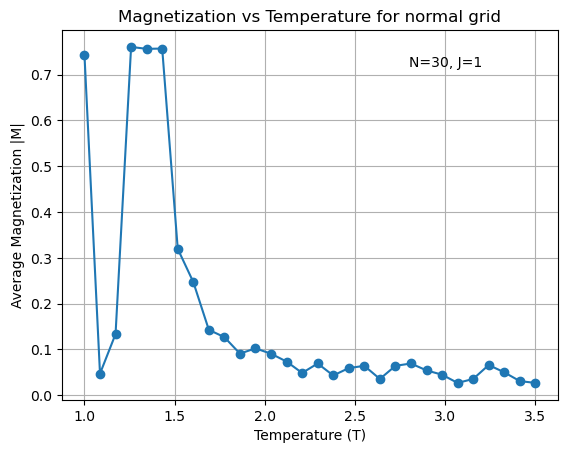

In [3]:
# --- Parameters ---
N = 30            # Lattice size
J = 1            # Coupling constant
temps = np.linspace(1, 3.5, 30)  # Temperature range
eq_steps = 20  # Steps for equilibration
mc_steps = 30  # Steps for measurement
runs_per_T = 10    # Average over multiple runs
newGrid = Grid(n_x=N, n_y=N, gridPointObject=electron.ClassicElectron)
isingModel = ClassicIsing(newGrid, temperature=temps[0], ferromagnetivity=J,Mf_External=0)

def B_vs_T(temps, eq_steps, mc_steps, runs_per_T):
    magnetizations = []
    for T in temps:
        newGrid = Grid(n_x=N, n_y=N, gridPointObject=electron.ClassicElectron)
        isingModel.grid = newGrid
        isingModel.temperature = T
        total_mag = 0
        for run in range(runs_per_T):
            #equilibration
            isingModel.runSimulation(eq_steps)
            #measurement
            isingModel.runSimulation(mc_steps)
            # calculate magnetization
            total_mag += isingModel.magnetization()
        avg_mag = total_mag / runs_per_T
        magnetizations.append(avg_mag)
        print(f"T={T:.2f}, <|M|>={magnetizations[-1]:.3f}")
    return magnetizations

mags = B_vs_T(temps, eq_steps, mc_steps, runs_per_T)

# graphing the results
plt.plot(temps, mags, marker='o')
plt.xlabel('Temperature (T)')
plt.ylabel('Average Magnetization |M|')
plt.title('Magnetization vs Temperature for normal grid')
plt.text(0.7, 0.9, f'N={N}, J={J}', transform=plt.gca().transAxes)
#plt.legend()
plt.grid()
plt.show()